In [1]:
import welly
import pandas as pd
import lasio
import numpy as np

from welly import Well

In [2]:
well = Well.from_las(r'C:\Users\mathe\Desktop\MATHEUS\UFBA\7º Semestre\Métodos Sísmicos\Projeto\Apoio\KK1.las')
# w.header                      # runing with welly lib we are not able to see las header data
well_las= lasio.read(r'C:\Users\mathe\Desktop\MATHEUS\UFBA\7º Semestre\Métodos Sísmicos\Projeto\Apoio\KK1.las')
well_las.header

c:\users\mathe\appdata\local\programs\python\python36\lib\site-packages\welly\well.py:173: FutureWarning: From v0.5 the default will be 'original', keeping whatever is used in the LAS file. If you want to force conversion to metres, change your code to use `index='m'`.
  warnings.warn(m, FutureWarning)
c:\users\mathe\appdata\local\programs\python\python36\lib\site-packages\welly\curve.py:217: UserWarning: Irregular sampling in depth is not supported. Interpolating to regular basis.
  warnings.warn(m)


{'Version': [HeaderItem(mnemonic="VERS", unit="", value="2.0", descr="CWLS LOG ASCII STAN...),
  HeaderItem(mnemonic="WRAP", unit="", value="NO", descr="SINGLE LINE PER DEPT...),
  HeaderItem(mnemonic="CREA", unit="", value="8/24/2012 12:51", descr="22")],
 'Well': [HeaderItem(mnemonic="STRT", unit="m", value="1517.0", descr="START DEPTH"),
  HeaderItem(mnemonic="STOP", unit="m", value="3850.7012", descr="STOP DEPTH"),
  HeaderItem(mnemonic="STEP", unit="m", value="0.1524", descr="STEP VALUE"),
  HeaderItem(mnemonic="NULL", unit="", value="-999.25", descr="NULL VALUE"),
  HeaderItem(mnemonic="SRVC", unit="", value="SCH", descr="Service Company/Log...),
  HeaderItem(mnemonic="DATE", unit="", value="08/24/2012", descr="LAS file Cre...),
  HeaderItem(mnemonic="WELL", unit="", value="KK1", descr="Well Name"),
  HeaderItem(mnemonic="COMP", unit="", value="NPK", descr="Company"),
  HeaderItem(mnemonic="FLD", unit="", value="DY", descr="Field"),
  HeaderItem(mnemonic="STATE", unit="", value="

In [3]:
well.data['DT'] = well.data['DT'] / 0.3048   #unit convert to µs/m
well.data['RHOB'] = well.data['RHOB'] * 1000  #unit convert to kg/m3

In [4]:
#Despiking
#Sonic Despiking
dt = well.data['DT']
well.data['DT_DS'] = dt.despike(window_length=50, z=2)

#Density Despiking
den = well.data['RHOB']
well.data['RHOB_DS'] = den.despike(window_length=50, z=2)

In [5]:
#Smoothing 
#Sonic Smoothing
dt_ds = well.data['DT_DS']
well.data['DT_DS_SM'] = dt_ds.smooth(window_length=10, samples=False)

#Density Smoothing
den_ds = well.data['RHOB_DS']
well.data['RHOB_DS_SM'] = den_ds.smooth(window_length=10, samples=False)

In [6]:
log_start = 1517               # Depth of logging starts(m) from header
kb = 15                        # Kelly Bushing elevation(m) from header

In [7]:
gap_int = log_start - kb
repl_vel = 2632                # this is from VSP data knowledge (m/s)
log_start_time = 2.0 * gap_int / repl_vel        # 2 for twt

In [8]:
#first replace NaN values with zero
dt_iterval = np.nan_to_num(dt) * 0.1524 / 1e6
t_cum =  np.cumsum(dt_iterval) * 2
well.data['TWT'] = t_cum + log_start_time

In [9]:
df = well.df()

In [10]:
# Sonic velocity calculate
df['Vsonic'] = 1e6/df.DT_DS_SM

# AI calculate
df['AI'] = df['Vsonic'] * df['RHOB_DS_SM']        #(unit: kg/m2.s)

In [11]:
Imp = df['AI'].values
Rc=[]
for i in range(len(Imp)-1):
    Rc.append((Imp[i+1]-Imp[i])/(Imp[i]+Imp[i+1]))

# to adjust vector size copy the last element to the tail
Rc.append(Rc[-1])

In [12]:
# Let's add Rc into dataframe as new column
df['Rc'] = pd.Series(Rc, index=df.index)

In [13]:
df.head()

,DT,RHOB,SW,PHIE,DT_DS,RHOB_DS,DT_DS_SM,RHOB_DS_SM,TWT,Vsonic,AI,Rc
Depth,,,,,,,,,,,,
1517.0000,185.978669,1334.599972,NaN,NaN,185.978669,1334.599972,231.538315,1642.518456,1.141394,4318.939620,7.093938e+06,-0.004851
1517.1524,185.389769,1233.000040,NaN,NaN,185.389769,1233.000040,235.005109,1651.015497,1.141451,4255.226643,7.025445e+06,-0.003703
1517.3048,186.378286,1190.000057,NaN,NaN,186.378286,1190.000057,238.492810,1663.155496,1.141507,4192.998531,6.973609e+06,-0.002198
1517.4572,194.571525,1218.099952,NaN,NaN,194.571525,1218.099952,241.991691,1680.152419,1.141567,4132.373295,6.943017e+06,-0.001287
1517.6096,179.794291,1386.100054,NaN,NaN,179.794291,1386.100054,245.149686,1697.703188,1.141621,4079.140449,6.925170e+06,-0.000138


In [14]:
df.describe()

,DT,RHOB,SW,PHIE,DT_DS,RHOB_DS,DT_DS_SM,RHOB_DS_SM,TWT,Vsonic,AI,Rc
count,19404.000000,19404.000000,8349.000000,8349.000000,19404.000000,19404.000000,19404.000000,19404.000000,19404.000000,19404.000000,1.940400e+04,19404.000000
mean,230.851028,2488.168759,0.584059,0.092453,230.812958,2490.046847,230.788862,2489.885672,1.871561,4457.509579,1.118113e+07,0.000017
std,44.693290,177.700793,0.363845,0.067342,44.545450,170.161414,40.238531,143.820343,0.385164,726.493772,2.329307e+06,0.001542
min,161.049210,1190.000057,0.007100,0.000100,161.049210,1190.000057,165.637286,1642.518456,1.141394,2862.744531,5.365308e+06,-0.007749
25%,194.909691,2390.475035,0.227500,0.038800,194.909691,2390.199900,197.371710,2393.166145,1.557890,3905.562758,9.404106e+06,-0.000597
50%,224.520165,2507.050037,0.554200,0.083200,224.538212,2506.900072,224.378379,2511.167686,1.882455,4456.757396,1.130283e+07,0.000037
75%,256.476296,2613.600016,1.000000,0.139300,256.476296,2613.600016,256.045047,2598.146932,2.201411,5066.582241,1.306251e+07,0.000683
max,470.832364,2958.199978,1.000000,0.262400,449.043071,2958.199978,349.315138,2757.603077,2.506669,6037.288010,1.655836e+07,0.007963


In [15]:
dt = 0.001   #sampleing interval
t_max = 3.0   # max time to create time vector
t = np.arange(0, t_max, dt)
AI_tdom = np.interp(x=t, xp = df.TWT, fp = df.AI)

In [16]:
# again Rc calulation but in resampled time domain
Rc_tdom = []
for i in range(len(AI_tdom)-1):
    Rc_tdom.append((AI_tdom[i+1]-AI_tdom[i])/(AI_tdom[i]+AI_tdom[i+1]))
# to adjust vector size copy the last element to the tail
Rc_tdom.append(Rc_tdom[-1])

In [17]:
# define function of ricker wavelet
def ricker(f, length, dt):
    t0 = np.arange(-length/2, (length-dt)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t0**2)) * np.exp(-(np.pi**2)*(f**2)*(t0**2))
    return t0, y

In [18]:
f=20           #wavelet frequency
length=0.512  #Wavelet vector length
dt=dt           # Sampling prefer to use smiliar to resampled AI
t0, w = ricker(f, length, dt) # ricker wavelet 
synthetic = np.convolve(w, Rc_tdom, mode='same')

In [19]:
from bruges import filters

In [20]:
wave,t_wave = filters.wavelets.ormsby(0.512,dt=0.001,f=(5,10,35,60),return_t=True)
synthetic = np.convolve(wave, Rc_tdom, mode='same')

In [21]:
df_top = pd.read_csv(r'Tops.csv')
tops_dept = dict(df_top.values.tolist())  # convert to dictionary

In [22]:
def nearest_value(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [23]:
tops_dept

{'Am': 1519.4,
 'Pd': 1787.0,
 'Gp': 2244.0,
 'Lm': 2601.5,
 'Lf': 2709.4,
 'C4': 2886.0,
 'C6': 3036.9,
 'C7': 3177.8,
 'Kd': 3389.2,
 'Bg': 3537.0,
 'Gd': 3751.7,
 'H1': 4048.5,
 'H4': 4289.4}

In [24]:
TWT=df.TWT.values
tops_twt={}
for key, val in tops_dept.items():
    tops_twt[key]=TWT[nearest_value(df.index, val)]

In [25]:
import matplotlib.pyplot as plt

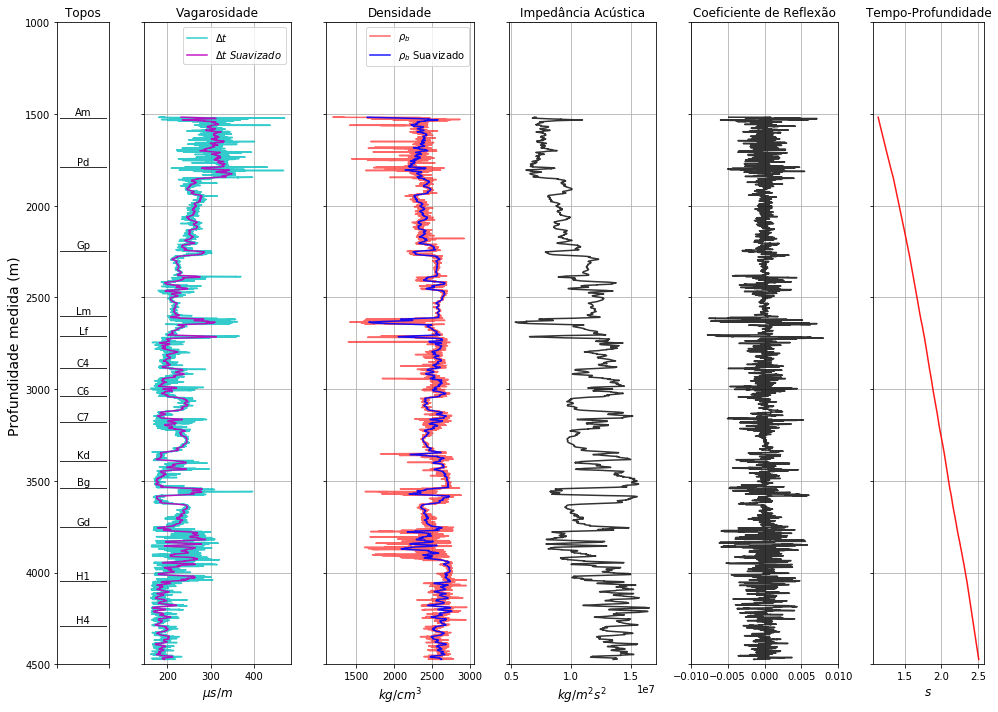

In [26]:
fig, axs = plt.subplots(1, 6, sharey=True, figsize = (14,10), gridspec_kw={'width_ratios': [0.7,2,2,2,2,1.5]})
fig.subplots_adjust(wspace=0.1)
# -----------------------------------------------------------------------------------track1------------
axs[0].set_title('Topos', style = 'normal')
axs[0].set_ylabel('Profundidade medida (m) ', fontsize = '14' )
axs[0].set_xticklabels('')
for Top in tops_dept.values() :
    axs[0].axhline( y = float(Top), color = 'k', lw = 1,   
                            alpha = 0.8, xmin = 0.05, xmax = 0.95 )
for Top, MD in tops_dept.items():
    axs[0].text( x = 0.5,  y = float(MD), s = Top,fontsize = '10', 
                horizontalalignment = 'center',verticalalignment = 'bottom')
# -----------------------------------------------------------------------------------track2------------
axs[1].plot(df.DT, df.index,'c', alpha=0.8, label='$\Delta t$')
axs[1].plot(df.DT_DS_SM, df.index,'m', alpha=0.9, label='$\Delta t \ Suavizado$')
axs[1].set_title('Vagarosidade', style = 'normal')
axs[1].set_xlabel( r'$\mu s/m $', fontsize = '12')
axs[1].set_ylim(1000, 5000)
axs[1].invert_yaxis()
axs[1].legend()
axs[1].grid()
# -----------------------------------------------------------------------------------track3------------
axs[2].plot( df.RHOB, df.index,'r', alpha=0.6, label='$\\rho_b$')
axs[2].plot( df.RHOB_DS_SM, df.index,'b', alpha=0.9, label='$\\rho_b$ Suavizado')
axs[2].set_title('Densidade', style = 'normal')
axs[2].set_xlabel('$kg/cm^3$', fontsize = '12')
axs[2].set_ylim(1000, 5000)
axs[2].invert_yaxis()
axs[2].legend()
axs[2].grid()
# -----------------------------------------------------------------------------------track4------------  
axs[3].plot( df.AI, df.index,'k', alpha=0.8)
axs[3].set_title('Impedância Acústica', style = 'normal')
axs[3].set_xlabel( r'$kg/m^2s^2$', fontsize = '12')
axs[3].set_ylim(1000, 5000)
axs[3].invert_yaxis()
axs[3].grid()
# -----------------------------------------------------------------------------------track5-----------
axs[4].plot( df.Rc, df.index,'k', alpha=0.8)
axs[4].set_title('Coeficiente de Reflexão', style = 'normal')
#axs[4].set_xlabel('Fração' , fontsize = '12')
axs[4].set_ylim(1000, 5000)
axs[4].set_xlim(-0.01, 0.01)
axs[4].invert_yaxis()
axs[4].grid()
# -----------------------------------------------------------------------------------track6------------
axs[5].plot( df.TWT, df.index,'r', alpha=0.9)
axs[5].set_title('Tempo-Profundidade', style = 'normal')
axs[5].set_xlabel( '$s$', fontsize = '12')
axs[5].set_ylim(1000, 4500)
axs[5].invert_yaxis()
# axs[5].set_yticklabels('')
axs[5].grid()
plt.tight_layout()
#plt.savefig('real_data_result', dpi=300)


In [27]:
df_offset_seis= pd.read_csv(r'around_well_seismic.csv')

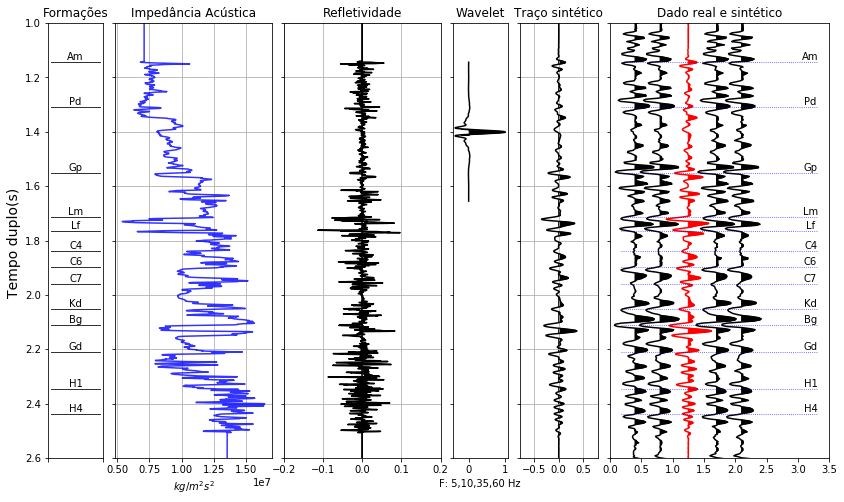

In [29]:
fig, axs = plt.subplots(1, 6, sharey=False, figsize = (14,8), gridspec_kw={'width_ratios': [0.7,2,2,0.7,1,2.8]})
fig.subplots_adjust(wspace=0.1)
# -----------------------------------------------------------------------------------track1------------
axs[0].set_title('Formações', style = 'normal')
axs[0].set_ylabel('Tempo duplo(s) ', fontsize = '14' )
axs[0].set_xticklabels('')
axs[0].set_ylim(1 , 2.6)
axs[0].invert_yaxis()

for Top in tops_twt.values() :
    axs[0].axhline( y = float(Top), color = 'k', lw = 1,   
                            alpha = 0.8, xmin = 0.05, xmax = 0.95 )
for Top, S in tops_twt.items():
    axs[0].text( x = 0.5,  y = float(S), s = Top,fontsize = '10', 
                horizontalalignment = 'center',verticalalignment = 'bottom')
# -----------------------------------------------------------------------------------track2------------
axs[1].plot( AI_tdom, t,'b', alpha=0.8)
axs[1].set_title('Impedância Acústica', style = 'normal')
axs[1].set_xlabel( r'$kg/m^2s^2$', fontsize = '10')
axs[1].set_ylim(1 , 2.6)
axs[1].set_yticklabels('')
axs[1].invert_yaxis()
axs[1].grid()
# -----------------------------------------------------------------------------------track3------------
axs[2].plot( Rc_tdom, t,'k')
axs[2].plot([0, 0], [t.min(), t.max()], '-', c='k')
axs[2].set_title('Refletividade', style = 'normal')
axs[2].set_ylim(1 , 2.6)
axs[2].set_xlim(-0.2 , 0.2)
axs[2].set_yticklabels('')
axs[2].invert_yaxis()
axs[2].grid()
# -----------------------------------------------------------------------------------track4------------   
axs[3].plot( wave, t_wave+1.4,'black', alpha=0.99)
axs[3].fill_betweenx(t_wave+1.4 , wave,  0,  w > 0.0,  color='black')
axs[3].set_title('Wavelet', style = 'normal')
axs[3].set_xlabel('F: 5,10,35,60 Hz' , fontsize = '10')
axs[3].set_yticklabels('')
axs[3].set_ylim(1 , 2.6)
axs[3].invert_yaxis()
# -----------------------------------------------------------------------------------track5------------
axs[4].plot( synthetic, t ,'black')
axs[4].fill_betweenx(t, synthetic,  0,  synthetic > 0,  color='black')
axs[4].set_title('Traço sintético', style = 'normal')
axs[4].set_ylim(1 , 2.6)
axs[4].set_xlim(-0.8 , 0.8)
axs[4].invert_yaxis()
axs[4].set_yticklabels('')
axs[4].grid()
# -----------------------------------------------------------------------------------track6------------
offsets=[0.4, 0.8 , 1.25, 1.7, 2.1]

x1= (df_offset_seis.cdp409.values/1e5) + offsets[0]
x2= (df_offset_seis.cdp410.values/1e5) + offsets[1]
x3= (df_offset_seis.cdp412.values/1e5) + offsets[3]
x4= (df_offset_seis.cdp413.values/1e5) + offsets[4]
t_sei=df_offset_seis.time

axs[5].plot( x1, t_sei ,'k')
axs[5].fill_betweenx(t_sei, offsets[0] , x1, where=(x1>offsets[0]),color='k')
axs[5].plot( x2, t_sei ,'k')
axs[5].fill_betweenx(t_sei, offsets[1] , x2, where=(x2>offsets[1]),color='k')
axs[5].plot( synthetic+offsets[2], t ,'r')
axs[5].fill_betweenx(t, offsets[2] , (synthetic+offsets[2]),
                     where=((synthetic+offsets[2])>offsets[2]),color='r')
axs[5].plot( x3, t_sei ,'k')
axs[5].fill_betweenx(t_sei, offsets[3] , x3, where=(x3>offsets[3]),color='k')
axs[5].plot( x4, t_sei ,'k')
axs[5].fill_betweenx(t_sei, offsets[4] , x4, where=(x4>offsets[4]),color='k')

axs[5].set_title('Dado real e sintético', style = 'normal')
axs[5].set_yticklabels('')
#axs[5].set_xticklabels('')
axs[5].set_ylim(1 , 2.6)
axs[5].set_xlim(0 , 03.5)
axs[5].invert_yaxis()
for Top in tops_twt.values() :
    axs[5].axhline( y = float(Top), color = 'b', lw = 0.8, ls = ':', 
                   alpha = 0.8, xmin = 0.05, xmax = 0.95 )
for Top, S in tops_twt.items():
    axs[5].text( x = 3.2,  y = float(S), s = Top,fontsize = '10', 
                horizontalalignment = 'center',verticalalignment = 'bottom')    

#plt.savefig('real_data_ormsby', dpi=600)

### Dados sintéticos

In [155]:
from bruges import filters

#### Criando o modelo geológico

In [156]:
z = np.arange(100,800,0.1) #Vetor da profundidade de 100 - 800m
v = np.zeros(len(z))       #Criando um vetor nulo que será armazenado a velocidade
d = np.zeros(len(z))       #Criando um vetor nulo que será armazenado a densidade

In [61]:
for i in range(0,len(z)):
    if z[i]<=260:
        v[i]=1900 ; d[i]=2.55
    if z[i]>260 and z[i]<=300: 
        v[i]=2500 ; d[i]=2.55
    if z[i]>300 and z[i]<=385: 
        v[i]=2000 ; d[i]=2.4
    if z[i]>385 and z[i]<=405: 
        v[i]=3000 ; d[i]=2.65
    if z[i]>405 and z[i]<=450: 
        v[i]=2500 ; d[i]=2.55
    if z[i]>450 and z[i]<=520: 
        v[i]=3000 ; d[i]=2.65
    if z[i]>520 and z[i]<=600: 
        v[i]=2500 ; d[i] = 2.4
    if z[i]>600 and z[i]<=650: 
        v[i]=4500 ; d[i]=2.75
    if z[i]>650:
        v[i]=5000 ; d[i]=2.85

In [62]:
#Criando um DataFrame
df = pd.DataFrame({'Profundidade':z,'Vp':v,'Rho':d*1000}) #multiplicando densidade por 1000 (SI)
df.head()

,Profundidade,Vp,Rho
0,100.0,1900.0,2550.0
1,100.1,1900.0,2550.0
2,100.2,1900.0,2550.0
3,100.3,1900.0,2550.0
4,100.4,1900.0,2550.0


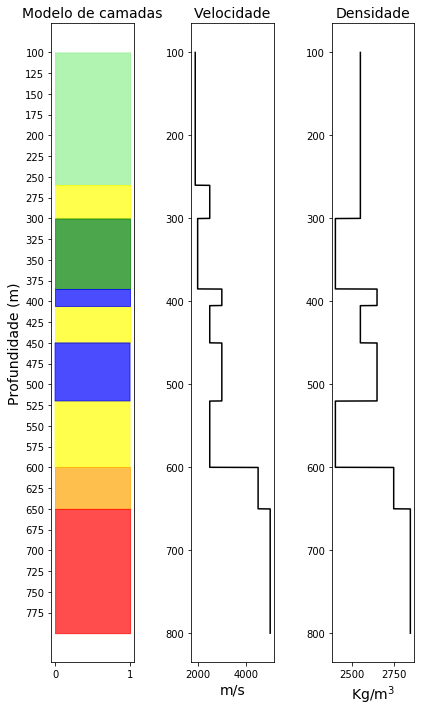

In [63]:

#Plotando o modelo geológico, velocidade e densidade
fig,axes = plt.subplots(ncols=3,figsize=(6,10))

for ax in axes:
    ax.invert_yaxis()

color = ['lightgreen','yellow','green','blue','orange','red']
for i,j in zip(df.Vp.unique(),color):
    axes[0].fill_betweenx(y=df.Profundidade,
                         x1=1,
                         x2=0,
                         where=df.Vp==i,
                         color=j, 
                         alpha=0.7)
    
axes[0].set_ylabel('Profundidade (m)', fontsize=14)
axes[0].set_title('Modelo de camadas', fontsize=14)
axes[0].set_yticks(np.arange(100,800,25))

axes[1].plot(df.Vp,df.Profundidade,color='black')
axes[1].set_title('Velocidade', fontsize=14)

axes[1].set_xlabel('m/s', fontsize=14)
axes[2].plot(df.Rho,df.Profundidade,color='black')
axes[2].set_xlabel('Kg/m$^3$', fontsize=14)
axes[2].set_title('Densidade', fontsize=14)

fig.tight_layout()

#plt.savefig('synth_model', dpi = 300)

Calculando a Impedância Acústica (AI)

In [64]:
df['AI'] = df['Vp']*df['Rho'] #Calculando a impedância acústica
df.head()

,Profundidade,Vp,Rho,AI
0,100.0,1900.0,2550.0,4845000.0
1,100.1,1900.0,2550.0,4845000.0
2,100.2,1900.0,2550.0,4845000.0
3,100.3,1900.0,2550.0,4845000.0
4,100.4,1900.0,2550.0,4845000.0


Calculando o coeficiente de reflexão (Rc)

In [65]:
#Calculando o coeficiente de reflexão
Rc = np.zeros(len(df['AI']))
for i in range(0,len(df['AI'])-1):
    Rc[i] = (df['AI'][i+1]-df['AI'][i])/(df['AI'][i+1]+df['AI'][i])
df['Rc'] = Rc
df.head()

,Profundidade,Vp,Rho,AI,Rc
0,100.0,1900.0,2550.0,4845000.0,0.0
1,100.1,1900.0,2550.0,4845000.0,0.0
2,100.2,1900.0,2550.0,4845000.0,0.0
3,100.3,1900.0,2550.0,4845000.0,0.0
4,100.4,1900.0,2550.0,4845000.0,0.0


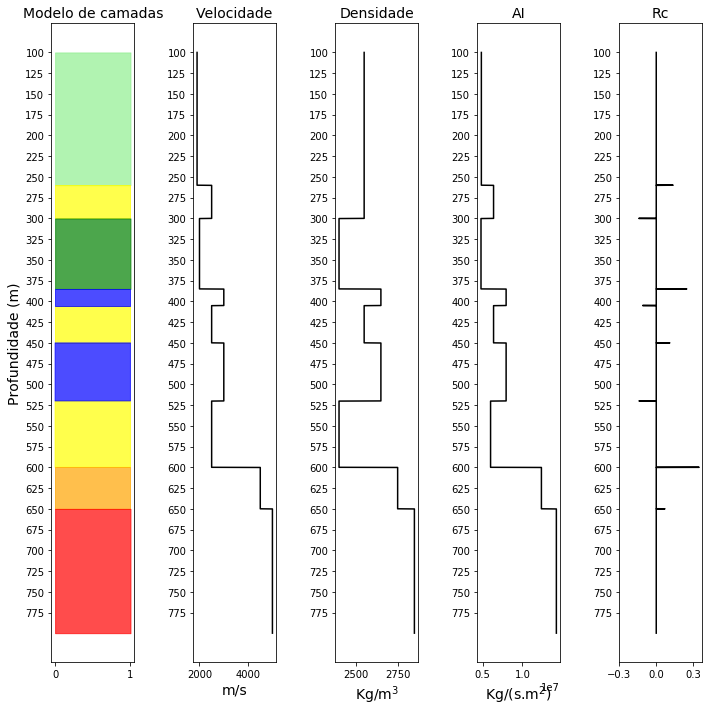

In [72]:

#Plotando o modelo geológico, velocidade e densidade
fig,axes = plt.subplots(ncols=5,figsize=(10,10))

for ax in axes:
    ax.invert_yaxis()

color = ['lightgreen','yellow','green','blue','orange','red']
for i,j in zip(df.Vp.unique(),color):
    axes[0].fill_betweenx(y=df.Profundidade,
                         x1=1,
                         x2=0,
                         where=df.Vp==i,
                         color=j, 
                         alpha=0.7)
    
axes[0].set_ylabel('Profundidade (m)', fontsize=14)
axes[0].set_title('Modelo de camadas', fontsize=14)


axes[1].plot(df.Vp,df.Profundidade,color='black')
axes[1].set_title('Velocidade', fontsize=14)
axes[1].set_xlabel('m/s', fontsize=14)

axes[2].plot(df.Rho,df.Profundidade,color='black')
axes[2].set_xlabel('Kg/m$^3$', fontsize=14)
axes[2].set_title('Densidade', fontsize=14)

axes[3].plot(df.AI, df.Profundidade, c='black')
axes[3].set_title('AI', fontsize=14)
axes[3].set_xlabel('Kg/(s.m$^2$)', fontsize=14)

axes[4].plot(df.Rc, df.Profundidade, c='black')
axes[4].set_title('Rc', fontsize=14)
axes[4].set_xticks(np.arange(-0.3,0.3+0.3,0.3))

for ax in axes:
    ax.set_yticks(np.arange(100,800,25))



fig.tight_layout()

#plt.savefig('synth_model_AI_RC', dpi = 300)

Convertendo profundidade em tempo

In [74]:
#Consideremos a velocidade média dos 100 primeiros metros 1700
df['Dt_SI'] = 1/df['Vp'] #Obtendo a vagarosidade no SI
#Calculando o Two-way-travel time
df['TWT']=(2*100/1700) + 2*(df['Profundidade'][1]-df['Profundidade'][0])*np.cumsum(df['Dt_SI']) 
df.head()

,Profundidade,Vp,Rho,AI,Rc,Dt_SI,TWT
0,100.0,1900.0,2550.0,4845000.0,0.0,0.000526,0.117752
1,100.1,1900.0,2550.0,4845000.0,0.0,0.000526,0.117858
2,100.2,1900.0,2550.0,4845000.0,0.0,0.000526,0.117963
3,100.3,1900.0,2550.0,4845000.0,0.0,0.000526,0.118068
4,100.4,1900.0,2550.0,4845000.0,0.0,0.000526,0.118173


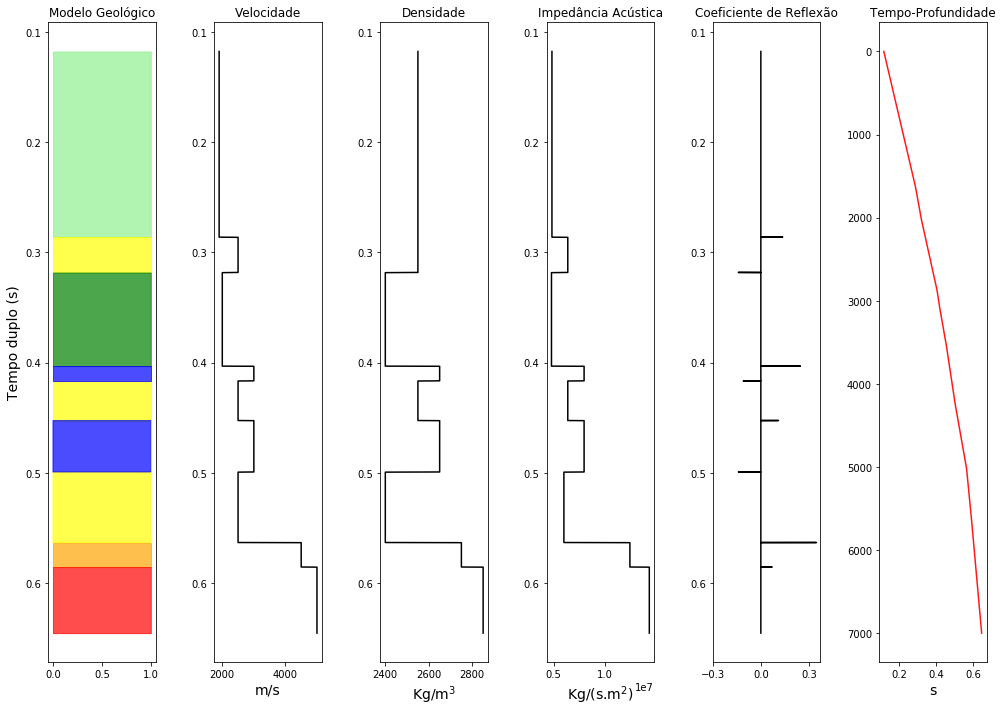

In [79]:

#Plotando modelo e o coeficiente de reflexão
fig,axes = plt.subplots(ncols=6,figsize=(14,10))

for ax in axes:
    ax.invert_yaxis()

for i,j in zip(df.Vp.unique(),color):
    axes[0].fill_betweenx(y=df.TWT,
                         x1=1,
                         x2=0,
                         where=df.Vp==i,
                         color=j,
                     alpha=0.7)
    
axes[0].set_title('Modelo Geológico', fontsize=12)
axes[0].set_ylabel('Tempo duplo (s)', fontsize=14)
    
axes[1].plot(df.Vp,df.TWT,color='black')
axes[1].set_title('Velocidade', fontsize=12)
axes[1].set_xlabel('m/s', fontsize=14)
#axes[1].set_ylabel('Tempo duplo (s)', fontsize=14)

axes[2].plot(df.Rho,df.TWT,color='black')
axes[2].set_title('Densidade', fontsize=12)
axes[2].set_xlabel('Kg/m$^3$', fontsize=14)

axes[3].plot(df.AI,df.TWT,color='black')
axes[3].set_title('Impedância Acústica', fontsize=12)
axes[3].set_xlabel('Kg/(s.m$^2$)', fontsize=14)

axes[4].plot(df.Rc,df.TWT,color='black')
axes[4].set_title('Coeficiente de Reflexão', fontsize=12)
axes[4].set_xticks(np.arange(-0.3,0.3+0.3,0.3))

axes[5].plot(df.TWT, df.index, c='red', alpha=0.9)
axes[5].set_title('Tempo-Profundidade', fontsize=12)
axes[5].set_xlabel('s',fontsize=14)

fig.tight_layout()

plt.savefig('cal_depth_time', dpi=300)

### Reamostrando o dado

In [80]:
#Reamostrando a impedância acústica para uma taxa de amostragem de 2ms
dt = 0.002
t = np.arange(0,df.TWT.max()+dt,dt)
Vp = np.interp(x=t,xp=df['TWT'],fp=df['Vp'])
AI = np.interp(x=t,xp=df['TWT'],fp=df['AI'])

In [81]:
#Calculando o coeficiente de reflexão
Rc = np.zeros(len(AI))
for i in range(0,len(Rc)-1):
    Rc[i] = (AI[i+1]-AI[i])/ (AI[i+1]+AI[i])

In [82]:
#Criando um DataFrame com as informações anteriores
trace = pd.DataFrame({'Time':t,
                      'Vp':Vp,
                     'AI':AI,
                     'Rc':Rc})
trace.head()

,Time,Vp,AI,Rc
0,0.000,1900.0,4845000.0,0.0
1,0.002,1900.0,4845000.0,0.0
2,0.004,1900.0,4845000.0,0.0
3,0.006,1900.0,4845000.0,0.0
4,0.008,1900.0,4845000.0,0.0


In [83]:
#Criando uma wavelet ricker utilizando o pacote bruges
#frequência de 25Hz, taxa de amostragem de 2ms e  tempo de duração de 128ms
wave_ricker,t_wave = filters.wavelets.ricker(0.128,dt=0.002,f=25,return_t=True)

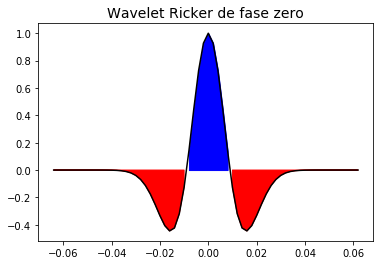

In [84]:
plt.title('Wavelet Ricker de fase zero', fontsize=14)
plt.plot(t_wave,wave_ricker,color='black')
plt.fill_between(x=t_wave,y1=wave_ricker,y2=0,where=(wave_ricker>0),color='blue')
plt.fill_between(x=t_wave,y1=wave_ricker,y2=0,where=(wave_ricker<0),color='red')

In [85]:
trace['t_synth_1'] = np.convolve(wave_ricker,trace.Rc,mode='same')

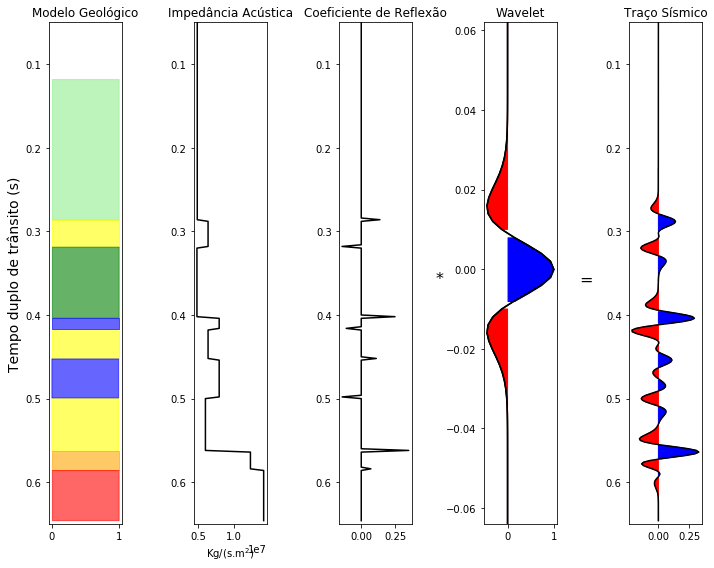

In [87]:
#Plotando o traço sísmico

fig,axes = plt.subplots(ncols=5,figsize=(10,8))

for ax in axes:
    ax.set_ylim(0.05,0.65)
    ax.invert_yaxis()


for i,j in zip(df.Vp.unique(),color):
    axes[0].fill_betweenx(y=df.TWT,
                         x1=1,
                         x2=0,
                         where=df.Vp==i,
                         color=j,
                     alpha=0.6)
    
axes[0].set_title('Modelo Geológico')
axes[0].set_ylabel('Tempo duplo de trânsito (s)', fontsize=14)

axes[1].plot(trace.AI,trace.Time,color='black')
axes[1].set_title('Impedância Acústica')
axes[1].set_xlabel('Kg/(s.m$^2$)')

axes[2].plot(trace.Rc,trace.Time,color='black')
axes[2].set_title('Coeficiente de Reflexão')

axes[3].plot(wave_ricker,t_wave,color='black')
axes[3].fill_betweenx(y=t_wave,
                     x1=wave_ricker,
                     x2=0,
                     where=wave_ricker>0,color='blue')

axes[3].plot(wave_ricker,t_wave,color='black')
axes[3].fill_betweenx(y=t_wave,
                     x1=wave_ricker,
                     x2=0,
                     where=wave_ricker<0,color='red')

axes[3].set_ylim(t_wave.min(),t_wave.max())

axes[3].set_title('Wavelet')

axes[4].plot(trace.t_synth_1,trace.Time,color='black')
axes[4].fill_betweenx(y=trace.Time,
                 x1=trace.t_synth_1,
                 x2=0,
                 where=trace.t_synth_1>0,color='blue')

axes[4].fill_betweenx(y=trace.Time,
                 x1=trace.t_synth_1,
                 x2=0,
                 where=trace.t_synth_1<0,color='red')

axes[4].set_title('Traço Sísmico')

fig.text(x=0.61,y=0.5,s='*',fontsize=16)

fig.text(x=0.81,y=0.5,s='=',fontsize=16)

fig.tight_layout()

#plt.savefig('result_final', dpi = 300)